# Лабораторная работа №9
## Проект

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from collections import Counter
from sklearn.cluster import KMeans

1. На первом этапе проводится предварительная обработка изображений, которая включает в себя удаление шума, повышение резкости изображений. С помощью этой обработки выделяются характерные детали, подавляется шум, повышается быстродействие, уменьшается объем информации. 

In [17]:
image = cv2.imread('img1.jpg')

In [18]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
denoised = cv2.GaussianBlur(gray, (5, 5), 0)
sharpness = cv2.filter2D(denoised, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))

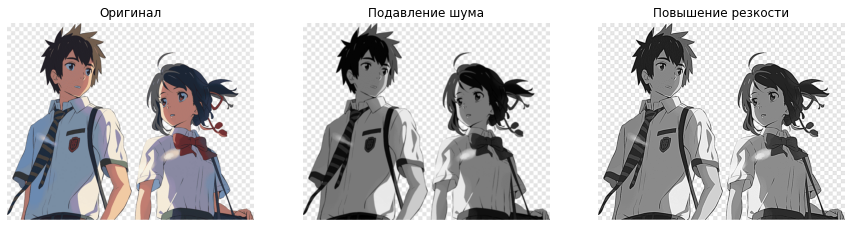

In [19]:
plt.figure(figsize=(15, 15))

plt.subplot(131)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Оригинал')
plt.axis('off')

plt.subplot(132)
plt.imshow(denoised, cmap='gray')
plt.title('Подавление шума')
plt.axis('off')

plt.subplot(133)
plt.imshow(sharpness, cmap='gray')
plt.title('Повышение резкости')
plt.axis('off')

plt.show();

2. Следующий шаг – удалении фона на изображении, для этого
сканируется все пространство изображения и отсканированные пиксели с одинаковой интенсивностью обнуляются. В результате интересующие нас объекты будут более четко выделены на черном фоне.

In [147]:
def shelf(image):
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    
    result = cv2.bitwise_and(image, image, mask=mask)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Оригинал')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title('Удаление фона')
    plt.axis('off')
    
    plt.show();

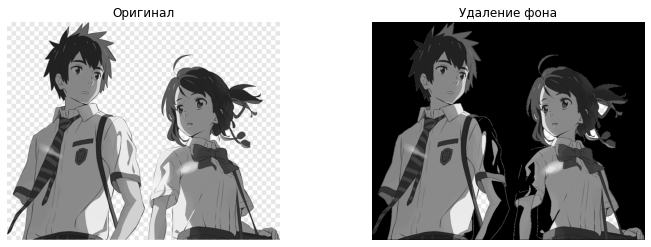

In [148]:
shelf(gray)

3. Для выделения объектов используется операция сегментации изображения методом водораздела, с последующей маркировкой результата сегментации.

In [77]:
def segment(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    im_bw = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)[1]
    
    kernel = np.ones((4, 3), np.uint8)
    opening = cv2.morphologyEx(im_bw, cv2.MORPH_OPEN, kernel, iterations=1)
    
    sure_bg = cv2.dilate(opening, kernel, iterations=1)
    
    dist_transform = cv2.distanceTransform(sure_bg, cv2.DIST_L2, 3)
    ret, sure_fg = cv2.threshold(dist_transform, 0.01 * dist_transform.max(), 255, cv2.THRESH_BINARY)
    sure_fg = np.uint8(sure_fg)
    
    unknown = cv2.Canny(sure_bg, 700, 100, apertureSize=3)

    ret, mark = cv2.connectedComponents(sure_fg)
    mark = mark + 1
    mark[unknown]
    
    markers = cv2.watershed(img, mark)
    
    img[markers == -1] = [255, 0, 0]
    
    plt.imshow(gray, cmap='gray')
    plt.title('Оригинал')
    plt.axis('off')
    plt.show();
    
    plt.imshow(im_bw, cmap='gray')
    plt.axis('off')
    plt.title('Пороговое преобразование')
    plt.show()
    
    plt.imshow(unknown, cmap='gray')
    plt.title('Canny')
    plt.axis('off')
    plt.show()
    
    return img

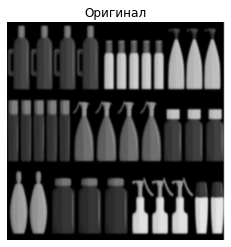

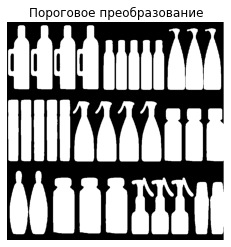

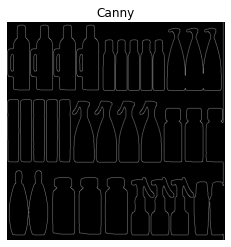

In [78]:
image = cv2.imread('img.jpg')
img = cv2.resize(image, (800, 800))
marker = segment(img)

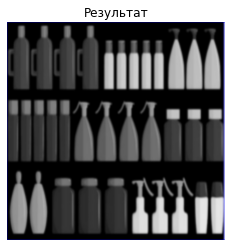

In [79]:
plt.imshow(cv2.cvtColor(marker, cv2.COLOR_BGR2RGB))
plt.title('Результат')
plt.axis('off')
plt.show();

4. С помощью операции распознавания объекта по шаблону каждый объект охватывается прямоугольной рамкой.


In [92]:
def match_template(image, template):  
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    
    result = cv2.matchTemplate(gray_image, gray_template, cv2.TM_CCOEFF_NORMED)
    
    threshold = 0.8
    loc = np.where(result >= threshold)
    
    for pt in zip(*loc[::-1]):
        cv2.rectangle(image, pt, (pt[0] + template.shape[1], pt[1] + template.shape[0]), (20, 126, 10), 1)
    
    plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
    plt.title('Шаблон')
    plt.axis('off')
    plt.show();

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))   
    plt.title('Распознавание объекта по шаблону')
    plt.axis('off')
    plt.show();

In [93]:
image= cv2.imread('img.jpg')
template = cv2.imread('template.jpg')

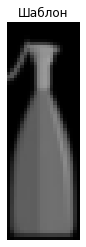

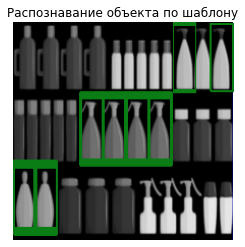

In [94]:
match_template(image, template)

5. Формирование таблицы признаков множества объектов.

In [129]:
img = cv2.imread('template.jpg', 0)

In [130]:
th = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

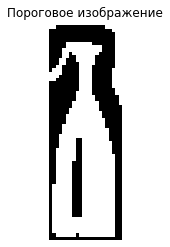

In [131]:
plt.imshow(th, cmap='gray')
plt.title('Пороговое изображение')
plt.axis('off')
plt.show()

In [132]:
contours, hierarchy = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cnt = contours[0]

area = cv2.contourArea(cnt)
perimeter = cv2.arcLength(cnt, True)
hull = cv2.convexHull(cnt)

x, y, w, h = cv2.boundingRect(cnt)
image_with_rectangle = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
print("x:", x)
print("y:", y)
print("Ширина:", w)
print("Высота:", h)

x: 0
y: 6
Ширина: 20
Высота: 59


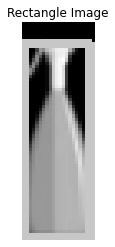

In [137]:
imag = cv2.rectangle(img,(x,y),(x+w,y+h),(123,255,255),2)
plt.imshow(imag, cmap='gray')
plt.title('Rectangle Image')
plt.axis('off')
plt.show();

In [110]:
# параметры бинарного изображения
epsilon = 0.1 * cv2.arcLength(cnt, True)
aspect_ratio = float(w) / h
rect_area = w * h
extent = float(area) / rect_area
hull_area = cv2.contourArea(hull)
equi_diameter = np.sqrt(4 * area / np.pi)

In [114]:
mask = np.zeros(img.shape, np.uint8)
cv2.drawContours(mask, [cnt], 0, 255, -1);

M = cv2.moments(cnt)

pixelpoints = np.transpose(np.nonzero(mask))
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(img, mask=mask)

leftmost = tuple(cnt[cnt[:, :, 0].argmin()][0])
rightmost = tuple(cnt[cnt[:, :, 0].argmax()][0])
topmost = tuple(cnt[cnt[:, :, 1].argmin()][0])
bottommost = tuple(cnt[cnt[:, :, 1].argmax()][0])

In [115]:
# Выво значений параметров
print("Площадь:", area)
print("Периметр:", perimeter)
print("Ширина, Высота:", w, h)
print("Соотношение сторон:", aspect_ratio)
print("Отношение площади к ограничивающему прямоугольнику:", extent)
print("Площадь выпуклой оболочки:", hull_area)
print("Эквивалентный диаметр:", equi_diameter)
print("Моменты:", M)
print("Самая левая точка:", leftmost)
print("Самая правая точка:", rightmost)
print("Самая верхняя точка:", topmost)
print("Самая нижняя точка:", bottommost)

Площадь: 0.0
Периметр: 64.0
Ширина, Высота: 33 1
Соотношение сторон: 33.0
Отношение площади к ограничивающему прямоугольнику: 0.0
Площадь выпуклой оболочки: 0.0
Эквивалентный диаметр: 0.0
Моменты: {'m00': 0.0, 'm10': 0.0, 'm01': 0.0, 'm20': 0.0, 'm11': 0.0, 'm02': 0.0, 'm30': 0.0, 'm21': 0.0, 'm12': 0.0, 'm03': 0.0, 'mu20': 0.0, 'mu11': 0.0, 'mu02': 0.0, 'mu30': 0.0, 'mu21': 0.0, 'mu12': 0.0, 'mu03': 0.0, 'nu20': 0.0, 'nu11': 0.0, 'nu02': 0.0, 'nu30': 0.0, 'nu21': 0.0, 'nu12': 0.0, 'nu03': 0.0}
Самая левая точка: (177, 213)
Самая правая точка: (209, 213)
Самая верхняя точка: (177, 213)
Самая нижняя точка: (177, 213)


 Распознавание объектов с помощью нейронной сети

In [139]:
s = [1249.0, 577.0, 180.5, 7795.5, 163.0, 111.0, 909.5, 29.5]
p = [157.55, 141.34, 90.476, 1262.1, 61.799, 78.064, 175.47, 48.730]
w = [31, 51, 7, 66, 15, 5, 24, 5]
h = [54, 26, 41, 158, 22, 37, 70, 22]
kw = [0.574, 1.9615, 0.1707, 0.4177, 0.6818, 0.1351, 0.3429, 0.2272]
ks = [0.7461, 0.4351, 0.6289, 0.7475, 0.4939, 0.6, 0.5414, 0.2682]
d = [39.878, 27.105, 15.160, 99.627, 14.406, 11.888, 34.029, 6.1287]
m0 = [1249.0, 577.0, 180.5, 7795.5, 163.0, 111.0, 909.5, 29.5]
m1 = [15994, 18479, 3319.8, 255475, 790.83, 174.5, 8059.0, 40.833]
m2 = [27883, 4990.2, 1440.7, 616222, 1220.3, 2033.3, 21165, 160.5]
m3 = [307788, 175877, 180.5, 19613900, 4657.8, 3300.2, 153434, 152.375]
weights = [0.3, 0.5, 0.1, 0.2, 1, 1, 1, 1, 1, 1, 1]

In [140]:
def sum(a, b):
    assert(len(a) == len(b))
    output = 0
    for i in range(len(a)):
        output += (a[i] * b[i])
    return output

In [141]:
def art_neuron(input, weights):
    pred = sum(input, weights)
    return pred

In [142]:
in0 = [s[0], p[0], w[0], h[0], kw[0], ks[0], d[0], m0[0], m1[0], m2[0], m3[0]]
in1 = [s[1], p[1], w[1], h[1], kw[1], ks[1], d[1], m0[1], m1[1], m2[1], m3[1]]
in2 = [s[2], p[2], w[2], h[2], kw[2], ks[2], d[2], m0[2], m1[2], m2[2], m3[2]]
in3 = [s[3], p[3], w[3], h[3], kw[3], ks[3], d[3], m0[3], m1[3], m2[3], m3[3]]
in4 = [s[4], p[4], w[4], h[4], kw[4], ks[4], d[4], m0[4], m1[4], m2[4], m3[4]]
in5 = [s[5], p[5], w[5], h[5], kw[5], ks[5], d[5], m0[5], m1[5], m2[5], m3[5]]

In [146]:
print("in0:", in0)
print("in5:", in5)

in0: [1249.0, 157.55, 31, 54, 0.574, 0.7461, 39.878, 1249.0, 15994, 27883, 307788]
in5: [111.0, 78.064, 5, 37, 0.1351, 0.6, 11.888, 111.0, 174.5, 2033.3, 3300.2]


In [144]:
pred0 = art_neuron(in0, weights)
pred1 = art_neuron(in1, weights)
pred2 = art_neuron(in2, weights)
pred3 = art_neuron(in3, weights)
pred4 = art_neuron(in4, weights)
pred5 = art_neuron(in5, weights)

In [145]:
print("pred0:", pred0)
print("pred1:", pred1)
print("pred2:", pred2)
print("pred3:", pred3)
print("pred4:", pred4)
print("pred5:", pred5)

pred0: 353422.5731
pred1: 200206.7716
pred2: 5245.747600000001
pred3: 20496501.1922
pred4: 6933.2112
pred5: 5711.8551
